In [0]:
# Change directory to VSCode workspace root so that relative path loads work correctly. Turn this addition off with the DataScience.changeDirOnImportExport setting
# ms-python.python added
import os
try:
	os.chdir(os.path.join(os.getcwd(), '..\\..\..'))
	print(os.getcwd())
except:
	pass


# Incremental learning checks

## Dataset extraction

In [152]:
import pandas as pd 
from sklearn import datasets

ds = datasets.load_iris()
features_values_2_D = ds.data[:, 0:2]
target_values = ds.target
X = features_values_2_D
y = target_values


In [153]:
class AdalineSGD(object):
    """ADAptive LInear NEuron classifier.
        Parameters
        ------------
        eta : float
        Learning rate (between 0.0 and 1.0)
        n_iter : int
        Passes over the training dataset.
        shuffle : bool (default: True)
        Shuffles training data every epoch if True
        to prevent cycles.
        random_state : int
        Random number generator seed for random weight
        initialization.
        Attributes
        -----------
        w_ : 1d-array
        Weights after fitting.
        cost_ : list
        Sum-of-squares cost function value averaged over all
        training samples in each epoch.
    """
    def __init__(self, eta=0.01, n_iter=10,
                    shuffle=True, random_state=None):
        self.eta = eta
        self.n_iter = n_iter
        self.w_initialized = False
        self.shuffle = shuffle
        self.random_state = random_state

    def fit(self, X, y):
        """ Fit training data.
        Parameters
        ----------
        X : {array-like}, shape = [n_samples, n_features]
        Training vectors, where n_samples is the number
        of samples and
        n_features is the number of features.
        y : array-like, shape = [n_samples]
        Target values.
        Returns
        -------
        self : object
        """
        self._initialize_weights(X.shape[1])
        self.cost_ = []
        for i in range(self.n_iter):
            if self.shuffle:
                X, y = self._shuffle(X, y)
            cost = []
            for xi, target in zip(X, y):
                cost.append(self._update_weights(xi, target))
            avg_cost = sum(cost) / len(y)
            self.cost_.append(avg_cost)
        
        return self

    def partial_fit(self, X, y):
        """Fit training data without reinitializing the weights"""
        if not self.w_initialized:
            self._initialize_weights(X.shape[1])
        if y.ravel().shape[0] > 1: #if we have more than one sample
            for xi, target in zip(X, y):
                self._update_weights(xi, target)
        else:
            self._update_weights(X, y)
        
        return self
        
    def _shuffle(self, X, y):
        """Shuffle training data"""
        r = self.rgen.permutation(len(y))
        
        return X[r], y[r]

    def _initialize_weights(self, m):
        """Initialize weights to small random numbers"""
        import numpy as np

        self.rgen = np.random.RandomState(self.random_state)
        self.w_ = self.rgen.normal(loc=0.0, scale=0.01,
                                   size=1 + m)
        
        self.w_initialized = True

    def _update_weights(self, xi, target):
        """Apply Adaline learning rule to update the weights"""
        output = self.activation(self.net_input(xi))
        error = (target - output)
        self.w_[1:] += self.eta * xi.dot(error)
        self.w_[0] += self.eta * error
        cost = 0.5 * error**2
    
        return cost

    def net_input(self, X):
        """Calculate net input"""
        
        return np.dot(X, self.w_[1:]) + self.w_[0]

    def activation(self, X):
        """Compute linear activation"""
        return X

    def predict(self, X):
        """Return class label after unit step"""

        return np.where(self.activation(self.net_input(X))
                        >= 0.0, 1, -1)


In [154]:
import numpy as np 

X_std = np.copy(X)
X_std[:,0] = (X[:,0] - X[:,0].mean()) / X[:,0].std()
X_std[:,1] = (X[:,1] - X[:,1].mean()) / X[:,1].std()

 Adaline via SGD fitting:

In [155]:
ada = AdalineSGD(n_iter=30, eta=0.01, random_state=1)
ada_model = ada.fit(X_std, y)


 pesos actuales del modelo

In [156]:
print('current model weights: {}'.format(ada_model.w_)) 


current model weights: [ 0.99379016  0.59744294 -0.26492416]


In [157]:
from matplotlib.colors import ListedColormap
def plot_decision_regions(X, y, classifier, resolution=0.02):
    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])
    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)

    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())
    # plot class samples
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1],
                    alpha=0.8, c=colors[idx],
                    marker=markers[idx], label=cl,
                    edgecolor='black')


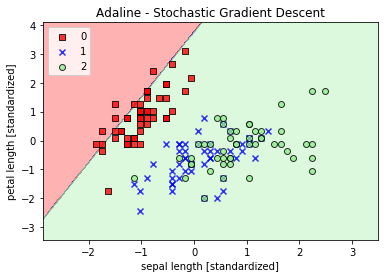

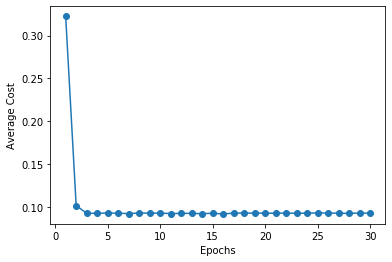

In [158]:
import matplotlib.pyplot as plt

# Plot decision regions
plot_decision_regions(X_std, y, classifier=ada_model)
plt.title('Adaline - Stochastic Gradient Descent')
plt.xlabel('sepal length [standardized]')
plt.ylabel('petal length [standardized]')
plt.legend(loc='upper left')
plt.show()
plt.plot(range(1, len(ada_model.cost_) + 1), ada_model.cost_, marker='o')
plt.xlabel('Epochs')
plt.ylabel('Average Cost')
plt.show()


# Ahora probamos a entrenar el modelo sobre un 90% de los datos con fit, y el 10% de uno en uno con partial_fit

In [159]:
len_90_ = int(0.9*len(X_std))
X_std_90_ = X_std[:len_90_]
y_90_ = y[:len_90_]

ada = AdalineSGD(n_iter=30, eta=0.01, random_state=1)
ada_model = ada.fit(X_std, y)
print('coefficients with all the dataset and 30 iters: {}'.format(ada_model.w_))

coefficients with all the dataset and 30 iters: [ 0.99379016  0.59744294 -0.26492416]


In [162]:
ada = AdalineSGD(n_iter=30, eta=0.01, random_state=1)
ada_model_90_ = ada.fit(X_std_90_, y_90_)
print('coefficients of model trained with 90 percent of the dataset and 30 iters: {}'.format(ada_model_90_.w_))


coefficients of model trained with 90 percent of the dataset and 30 iters: [ 0.94852038  0.56175896 -0.2872887 ]


In [163]:
index = (len_90_+1) - len_90_
X_single_sample = X_std[index]
y_single_sample = y[index]

ada_model_90_partially_refitted = ada_model_90_.partial_fit(X_single_sample, 
                                                            y_single_sample)

print('coefficients of model trained with 90 percent + 1 sample of the dataset and 30 iters: {}'.format(ada_model_90_.w_))

coefficients of model trained with 90 percent + 1 sample of the dataset and 30 iters: [ 0.94507701  0.56569479 -0.28683425]


In [164]:
index = (len_90_+5) - (len_90_+4)
X_single_sample = X_std[index]
y_single_sample = y[index]

latest_ada_model_partially_refitted = ada_model_90_partially_refitted.partial_fit(X_single_sample, 
                                                            y_single_sample)

print('coefficients of model trained with 90 percent + 2 samples of the dataset and 30 iters: {}'.format(latest_ada_model_partially_refitted.w_))

coefficients of model trained with 90 percent + 2 samples of the dataset and 30 iters: [ 0.94171367  0.56953915 -0.28639036]


In [165]:
index = (len_90_+8) - (len_90_+7)
X_single_sample = X_std[index]
y_single_sample = y[index]

latest_ada_model_partially_refitted = latest_ada_model_partially_refitted.partial_fit(X_single_sample, 
                                                            y_single_sample)

print('coefficients of model trained with 90 percent + 3 samples of the dataset and 30 iters: {}'.format(latest_ada_model_partially_refitted.w_))


coefficients of model trained with 90 percent + 3 samples of the dataset and 30 iters: [ 0.93842848  0.57329417 -0.28595678]


## MI PARTIAL FIT PARECE FUNCIONAR REENTRENÁNDOSE CON CADA MUESTRA ADICIONAL SOBRE EL MODELO YA PRE ENTRENADO CON GRAN PARTE DEL DATASET